# Installing Required Packages

In [1]:
%pip install "numpy==1.26.4" "opencv-python-headless==4.9.0.80" pillow esdk-obs-python

Note: you may need to restart the kernel to use updated packages.


# Importing Libraries

In [2]:
import base64, json
from pathlib import Path
import numpy as np
import cv2
from PIL import Image, ImageDraw

import os, uuid, pathlib
from obs import ObsClient
from ipywidgets import FileUpload, VBox
from IPython.display import display

from io import BytesIO
from typing import Optional


# Uploading QR Code to OBS and Connecting to OBS

In [ ]:
OBS_ENDPOINT = "https://xxxxx.com"
OBS_AK = "xxxx"
OBS_SK = "xxxx"
OBS_BUCKET = "xxxxx"

def _client():
    return ObsClient(access_key_id=OBS_AK,
                     secret_access_key=OBS_SK,
                     server=OBS_ENDPOINT.strip().rstrip("/"))

def obs_put_bytes(bucket, key, data: bytes):
    cli = _client()
    try:
        resp = cli.putContent(bucket, key, data)
    finally:
        cli.close()
    if resp.status >= 300:
        raise RuntimeError(f"putContent failed: {resp.errorMessage}")
    return resp


def obs_get_bytes(bucket, key) -> bytes:
    cli = _client()
    try:
        
        resp = cli.getObject(bucket, key, loadStreamInMemory=True)
        if resp.status >= 300:
            raise RuntimeError(f"getObject failed: {resp.errorMessage}")

        
        body_buf = getattr(resp.body, "buffer", None)
        if body_buf is not None:
            return body_buf

        #
        r = getattr(resp.body, "response", None)
        if r is not None:
            
            if hasattr(r, "read"):
                return r.read()
            
            if hasattr(r, "iter_content"):
                chunks = []
                for ch in r.iter_content(chunk_size=1024 * 1024):
                    if ch:
                        chunks.append(ch)
                return b"".join(chunks)

       
        raise RuntimeError("“The OBS body was empty or returned an unrecognized type.”")
    finally:
        cli.close()



LAST_OBJECT_KEY: Optional[str] = None
LAST_FILE_NAME: Optional[str] = None 

import re

def build_ui():
    up = FileUpload(accept='image/*', multiple=False)

    up.description = "Upload Your QR"   
    up.icon = "upload"                
    up.button_style = "primary"       
    up.tooltip = "Select an image from your computer"  
    up.layout.width = "220px"         
    up.layout.height = "36px"         
    up.style.button_color = "#3364AD" 
    up.style.font_size = "14px"      
    up.style.description_width = "120px"  
    up.value = ()
    up.layout.border_radius = "12px"




    def _on_change(change):
        if not up.value:
            return
        f = up.value[0]
        fname = f.name

        
        content = f.content
        if isinstance(content, memoryview):
            content = content.tobytes()
        elif isinstance(content, bytearray):
            content = bytes(content)
        elif not isinstance(content, (bytes, bytearray)):
            content = bytes(content)

        
        safe_fname = re.sub(r'[^A-Za-z0-9._-]+', '_', fname)
        object_key = f"uploads/{uuid.uuid4().hex}_{safe_fname}"

        obs_put_bytes(OBS_BUCKET, object_key, content)

        global LAST_OBJECT_KEY, LAST_FILE_NAME
        LAST_OBJECT_KEY = object_key
        LAST_FILE_NAME = fname

        container.children = (build_ui(),)

        from IPython.display import Markdown, display
        display(Markdown(f"✅ **Uploaded to OBS:** `{object_key}`\n\n"
                         f"Now, when you run cell 5, this image will be processed automatically."))
        
    up.observe(_on_change, names='value')
    return up

container = VBox()
container.children = (build_ui(),)
display(container)

✅ **Uploaded to OBS:** `uploads/ace61fc36c684007a8abdb1a6b3729ec_esras.jpg`

Now, when you run cell 5, this image will be processed automatically.

# Detecting the QR Code from OBS

In [4]:
def read_bgr(path: str):
    img = cv2.imread(path)
    if img is None:
        raise FileNotFoundError(f"The image could not be opened. {path}")
    return img

def detect_qr(img_bgr):
    qrd = cv2.QRCodeDetector()
    results = []
    try:
        retval, decoded_info, points, _ = qrd.detectAndDecodeMulti(img_bgr)
    except TypeError:
        decoded_info, points = [], None
        data, pts = qrd.detectAndDecode(img_bgr)
        if data:
            decoded_info = [data]
            points = np.array([pts], dtype=np.float32) if pts is not None else None
        retval = len(decoded_info) > 0

    if retval and points is not None and len(decoded_info) > 0:
        for data, pts in zip(decoded_info, points):
            if not data or pts is None:
                continue
            poly = pts.reshape(-1, 2)
            x_min, y_min = float(np.min(poly[:,0])), float(np.min(poly[:,1]))
            x_max, y_max = float(np.max(poly[:,0])), float(np.max(poly[:,1]))
            results.append({
                "type": "QR",
                "data": str(data),
                "polygon": poly.astype(float).tolist(),
                "bbox": {"x": x_min, "y": y_min, "w": x_max-x_min, "h": y_max-y_min},
            })
    return results

def cv_to_pil(bgr):
    return Image.fromarray(cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB))

def annotate(img_bgr, detections, color=(0,255,0), width=4):
    """Draws a box and text around the QR code."""
    pil = cv_to_pil(img_bgr).copy()
    draw = ImageDraw.Draw(pil)
    for det in detections:
        poly = det["polygon"]
        pts = [(float(x), float(y)) for x,y in poly]
        draw.line(pts + [pts[0]], fill=tuple(color), width=width)
        x, y = int(det["bbox"]["x"]), int(det["bbox"]["y"])
        label = f'QR: {det["data"][:48]}{"..." if len(det["data"])>48 else ""}'
        for dx, dy in [(-1,0),(1,0),(0,-1),(0,1)]:
            draw.text((x+dx, y+dy), label, fill=(0,0,0))
        draw.text((x, y), label, fill=(255,255,255))
    return pil


def read_bgr_obs(object_key: str):
    """Fetches an object (image/*) from OBS as bytes and converts it to BGR."""

    data = obs_get_bytes(OBS_BUCKET, object_key)
    arr = np.frombuffer(data, dtype=np.uint8)
    bgr = cv2.imdecode(arr, cv2.IMREAD_COLOR)
    if bgr is None:
        raise ValueError(f"OBS object could not be decoded as an image: {object_key}")
    return bgr

def read_bgr_auto(src: str):
    p = Path(src)
    if p.exists():
        return read_bgr(str(p))
    return read_bgr_obs(src)


# Displaying the QR Code fetched from OBS and Uploading the Result Again


=== uploads/ace61fc36c684007a8abdb1a6b3729ec_esras.jpg ===
[
  {
    "type": "QR",
    "data": "https://www.linkedin.com/in/esra-bingol?fromQR=1",
    "polygon": [
      [
        12.0,
        12.0
      ],
      [
        466.9889831542969,
        12.0
      ],
      [
        467.9730224609375,
        467.7548522949219
      ],
      [
        12.0,
        467.0
      ]
    ],
    "bbox": {
      "x": 12.0,
      "y": 12.0,
      "w": 455.9730224609375,
      "h": 455.7548522949219
    }
  }
]


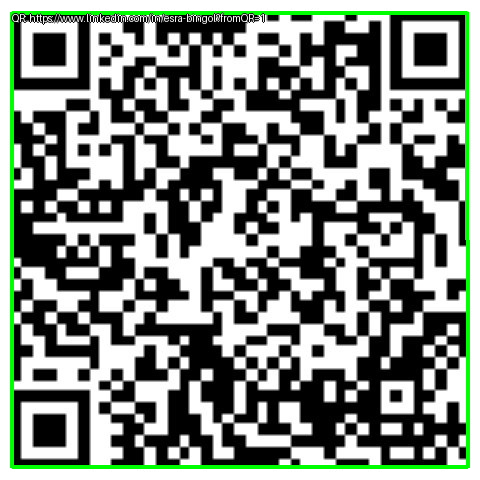


Saved to OBS (JSON): results/detections_219fb25f73f1485fa0bc63fa91e933b4.json


In [5]:
from IPython.display import display


if LAST_OBJECT_KEY:
    images = [LAST_OBJECT_KEY]          
else:
    images = [] 


RESULTS_PREFIX = "results"
JSON_KEY = f"{RESULTS_PREFIX}/detections_{uuid.uuid4().hex}.json"

all_results = []
for img_src in images:
    
    try:
        bgr = read_bgr_auto(img_src)
    except FileNotFoundError:
        print(f" Not found, skipping:{img_src}")
        continue

    
    h, w = bgr.shape[:2]
    if max(h, w) > 2200:
        scale = 2200 / float(max(h, w))
        bgr = cv2.resize(bgr, (int(w*scale), int(h*scale)), interpolation=cv2.INTER_AREA)

   
    dets = detect_qr(bgr)
    ann = annotate(bgr, dets)

    
    annotated_key = f"{RESULTS_PREFIX}/{uuid.uuid4().hex}_annotated.png"
    buf = BytesIO()
    ann.save(buf, format="PNG")
    obs_put_bytes(OBS_BUCKET, annotated_key, buf.getvalue())

    result = {"image": img_src, "detections": dets, "annotated_obs_key": annotated_key}
    all_results.append(result)

    print(f"\n=== {img_src} ===")
    print(json.dumps(dets, indent=2, ensure_ascii=False))
    display(ann) 

json_bytes = json.dumps(all_results, ensure_ascii=False, indent=2).encode("utf-8")
obs_put_bytes(OBS_BUCKET, JSON_KEY, json_bytes)
print("\nSaved to OBS (JSON):", JSON_KEY)


Image,Decoded & BBox,Preview
uploads/ace61fc36c684007a8abdb1a6b3729ec_esras.jpg,"QR — https://www.linkedin.com/in/esra-bingol?fromQR=1bbox: {""x"": 12.0, ""y"": 12.0, ""w"": 455.9730224609375, ""h"": 455.7548522949219}",Download annotated

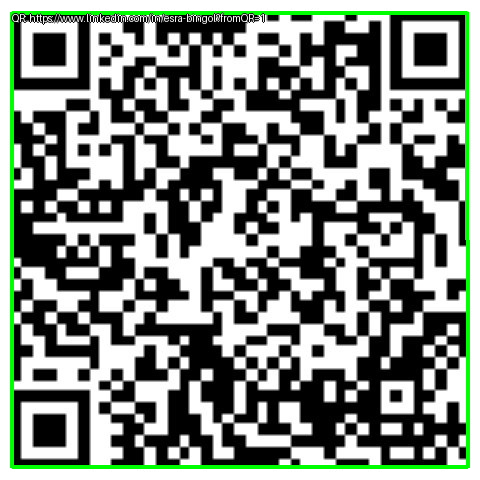
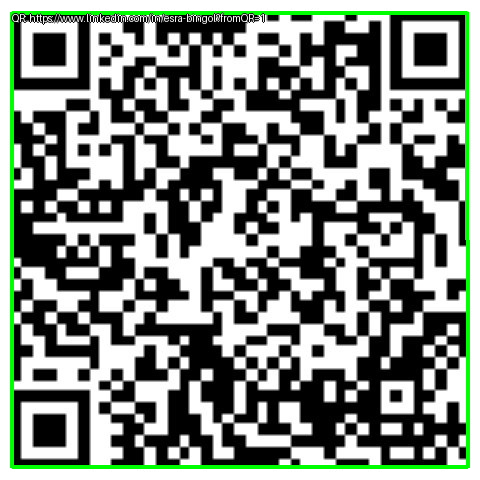

In [6]:
from IPython.display import HTML
import html, base64

def _obs_png_data_url(object_key: str) -> str:
    try:
        raw = obs_get_bytes(OBS_BUCKET, object_key)
        if not raw:
            return None
        b64 = base64.b64encode(raw).decode("ascii")
        return f"data:image/png;base64,{b64}"
    except Exception:
        return None

rows = []
for r in all_results:
    
    det_html = "<br>".join(
        f"<b>{html.escape(d.get('type',''))}</b> — "
        f"<code>{html.escape(str(d.get('data','')))}</code><br>"
        f"<small>bbox: {html.escape(json.dumps(d.get('bbox',{}), ensure_ascii=False))}</small>"
        for d in r.get("detections", [])
    ) or "<i>No codes detected</i>"

    
    ann_key = r.get("annotated_obs_key")
    data_url = _obs_png_data_url(ann_key) if ann_key else None

    if data_url:
        preview_html = f"""
        <img src="{data_url}"
             style="max-width:420px;border:1px solid #ddd;border-radius:8px;" />
        <div><a href="{data_url}" download>Download annotated</a></div>
        """
    else:
        preview_html = f"""
        <div style="color:#c00;">Preview could not be loaded.</div>
        <small>annotated_obs_key: <code>{html.escape(str(ann_key))}</code></small>
        """

    rows.append(f"""
    <tr>
      <td style="padding:8px 12px;"><code>{html.escape(str(r.get('image','')))}</code></td>
      <td style="padding:8px 12px;">{det_html}</td>
      <td style="padding:8px 12px;">{preview_html}</td>
    </tr>
    """)

HTML(f"""
<h3>QR Detection Results</h3>
<table style="border-collapse:collapse;">
  <thead><tr>
    <th style="text-align:left;padding:8px 12px;">Image</th>
    <th style="text-align:left;padding:8px 12px;">Decoded &amp; BBox</th>
    <th style="text-align:left;padding:8px 12px;">Preview</th>
  </tr></thead>
  <tbody>{''.join(rows)}</tbody>
</table>
""")
